In [1]:
import numpy as np  
import random
from sklearn.linear_model import LinearRegression  
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
from numpy.linalg import inv

import warnings
warnings.filterwarnings("ignore")

# Optional: suppress secure RNG warning from Opacus
import logging
logging.getLogger("opacus").setLevel(logging.ERROR)

In [2]:
from scipy.stats import norm
from scipy.optimize import bisect

def mu_to_epsilon(mu):
    """
    Compute the epsilon corresponding to a given mu under Gaussian Differential Privacy (GDP).
    
    Parameters:
    mu (float): The mu parameter in GDP.
    
    Returns:
    float: The corresponding epsilon value.
    """
    # Define the function whose root we want to find
    def func(epsilon):
        return mu + 2 * norm.ppf(1 / (1 + np.exp(epsilon)))
    
    # Use bisection method to find the root
    # Set reasonable bounds for epsilon
    epsilon_lower = 0.0
    epsilon_upper = 100.0  # Adjust as needed for higher mu values
    
    # Ensure that the function changes sign over the interval
    if func(epsilon_lower) * func(epsilon_upper) >= 0:
        raise ValueError("Bisection method fails: f(epsilon_lower) and f(epsilon_upper) must have opposite signs.")
    
    # Find the root
    epsilon = bisect(func, epsilon_lower, epsilon_upper, xtol=1e-10)
    return epsilon


In [3]:
from scipy.stats import norm
import numpy as np
from scipy.optimize import brentq
def delta_from_gdp(mu, eps):
    term1 = norm.cdf(-eps / mu + mu / 2)
    term2 = np.exp(eps) * norm.cdf(-eps / mu - mu / 2)
    return term1 - term2
def mu_from_eps_delta(eps, delta):
    def f(mu):
        return delta_from_gdp(mu, eps) - delta
    return brentq(f, 1e-5, 100)  # Choose a wide enough interval

def eps_from_mu_delta(mu, delta, eps_guess_range=(1e-5, 50)):
    # Solve δ = GDP(μ, ε) using root finding
    def f(eps):
        return delta_from_gdp(mu, eps) - delta
    
    return brentq(f, *eps_guess_range)

In [4]:
import numpy as np
import random

def mu_to_epsilon(mu):
    # Example conversion, modify as needed
    return mu

def privtree_binning_XY_with_theta(X, Y, x_bounds, mu, theta, branching_factor=2):
    """
    PrivTree Binning for (X,Y) using per-feature bounds.
    
    Parameters:
        X: ndarray (n, d) – feature matrix
        Y: ndarray (n,) – response vector
        x_bounds: list of (lb, ub) per feature
        mu: total privacy budget
        theta: splitting threshold
        branching_factor: usually 2 for binary splitting

    Returns:
        x_bins_list: list of bin boundary tuples (len B x d x 2)
        sum_x: ndarray (B, d)
        sum_y: ndarray (B,)
        counts: ndarray (B,)
        bin_counter: int
    """
    # --- Configuration ---
    beta = branching_factor
    epsilon = mu_to_epsilon(mu)
    lambda_ = (2 * beta - 1) / (beta - 1) / epsilon
    delta = lambda_ * np.log(beta)

    n_samples, n_features = X.shape
    # Add 1e-8 to upper bounds to ensure inclusivity
    initial_bins = [(lb, ub + 1e-8) for (lb, ub) in x_bounds]
    bins = [initial_bins]
    depths = [0]

    x_bins_list, sum_x, sum_y, counts = [], [], [], []
    bin_counter = 0
    assigned_mask = np.zeros(n_samples, dtype=bool)

    # --- Recursive Splitting ---
    while bins:
        current_bins = bins.pop(0)
        current_depth = depths.pop(0)

        bin_mask = np.all([
            (X[:, i] >= current_bins[i][0]) & (X[:, i] <= current_bins[i][1])
            for i in range(n_features)
        ], axis=0)

        X_bin, Y_bin = X[bin_mask], Y[bin_mask]
        N_bin = len(X_bin)

        S_Y_bin = np.sum(Y_bin)
        S_X_bin = np.sum(X_bin, axis=0)

        raw_score = N_bin - delta * current_depth
        biased_score = max(raw_score, theta - delta)
        noisy_score = biased_score + np.random.laplace(scale=lambda_)

        if noisy_score > theta:
            widths = [right - left for (left, right) in current_bins]
            i = np.argmax(widths)
            midpoint = (current_bins[i][0] + current_bins[i][1]) / 2
            left_bin, right_bin = list(current_bins), list(current_bins)
            left_bin[i] = (current_bins[i][0], midpoint)
            right_bin[i] = (midpoint, current_bins[i][1])
            bins += [left_bin, right_bin]
            depths += [current_depth + 1, current_depth + 1]
        else:
            counts.append(N_bin)
            x_bins_list.append(current_bins)
            sum_x.append(S_X_bin)
            sum_y.append(S_Y_bin)
            assigned_mask[bin_mask] = True
            bin_counter += 1

    # --- Post-processing: Ensure at least d+1 bins ---
    min_total_bins = n_features + 1
    if len(x_bins_list) == 0:
        bin_mask = np.all([
            (X[:, i] >= initial_bins[i][0]) & (X[:, i] <= initial_bins[i][1])
            for i in range(n_features)
        ], axis=0)
        X_bin, Y_bin = X[bin_mask], Y[bin_mask]
        x_bins_list = [initial_bins]
        sum_x = [np.sum(X_bin, axis=0)]
        sum_y = [np.sum(Y_bin)]
        counts = [len(X_bin)]

    while len(x_bins_list) < min_total_bins:
        volumes = [
            np.prod([right - left for (left, right) in bin_bounds])
            for bin_bounds in x_bins_list
        ]
        max_idx = np.argmax(volumes)
        current_bin = x_bins_list[max_idx]

        widths = [right - left for (left, right) in current_bin]
        max_width = max(widths)
        max_dims = [i for i, w in enumerate(widths) if w == max_width]
        split_dim = random.choice(max_dims)
        left_edge, right_edge = current_bin[split_dim]
        midpoint = (left_edge + right_edge) / 2

        left_bin = list(current_bin)
        right_bin = list(current_bin)
        left_bin[split_dim] = (left_edge, midpoint)
        right_bin[split_dim] = (midpoint, right_edge)

        bin_mask = np.all([
            (X[:, i] >= current_bin[i][0]) & (X[:, i] <= current_bin[i][1])
            for i in range(n_features)
        ], axis=0)
        X_bin, Y_bin = X[bin_mask], Y[bin_mask]

        left_mask = (X_bin[:, split_dim] < midpoint)
        right_mask = ~left_mask

        X_left, Y_left = X_bin[left_mask], Y_bin[left_mask]
        X_right, Y_right = X_bin[right_mask], Y_bin[right_mask]

        count_left = len(X_left)
        count_right = len(X_right)

        sum_x_left = np.sum(X_left, axis=0) if count_left > 0 else np.zeros(n_features)
        sum_y_left = np.sum(Y_left) if count_left > 0 else 0.0

        sum_x_right = np.sum(X_right, axis=0) if count_right > 0 else np.zeros(n_features)
        sum_y_right = np.sum(Y_right) if count_right > 0 else 0.0

        # Replace current bin with its two children
        x_bins_list.pop(max_idx)
        sum_x.pop(max_idx)
        sum_y.pop(max_idx)
        counts.pop(max_idx)

        x_bins_list.append(left_bin)
        sum_x.append(sum_x_left)
        sum_y.append(sum_y_left)
        counts.append(count_left)

        x_bins_list.append(right_bin)
        sum_x.append(sum_x_right)
        sum_y.append(sum_y_right)
        counts.append(count_right)

    return (
        x_bins_list,
        np.array(sum_x),
        np.array(sum_y),
        np.array(counts),
        bin_counter
    )


### Our Method

In [5]:
def DP_fy_sum_x_y_counts_syn_data(sum_x, sum_y, counts, x_bins_list, sens_y, priv_budget):
    """
    Generate synthetic data from privatized sufficient statistics.
    Also compute sum of synthetic x and y within each bin.

    Returns:
        X_syn: ndarray (n_total, d) — All synthetic features
        y_syn: ndarray (n_total,) — All synthetic responses
        noisy_sum_x_all: ndarray (K, d) — Sum of synthetic x's within each bin
        noisy_sum_y_all: ndarray (K,) — Sum of synthetic y's within each bin
        tilde_counts: ndarray (K,) — Privatized count per bin (0 if skipped)
    """
    epsilon_c = priv_budget / np.sqrt(3)
    epsilon_s = priv_budget / np.sqrt(3)
    epsilon_y = priv_budget / np.sqrt(3)

    K, d = sum_x.shape
    x_bins_list = np.array(x_bins_list)
    sens_x = np.maximum(np.abs(x_bins_list[..., 0]), np.abs(x_bins_list[..., 1]))

    X_syn = []
    y_syn = []

    noisy_sum_x_all = np.zeros((K, d))
    noisy_sum_y_all = np.zeros(K)
    noisy_counts = np.zeros(K, dtype=int)

    for k in range(K):
        c_k = counts[k]
        s_k = sum_x[k]
        t_k = sum_y[k]
        delta_s_k = sens_x[k]

        # Step 1: privatize count
        tilde_c_k = int(np.round(c_k + np.random.normal(0, 1 / epsilon_c)))
        if tilde_c_k <= 1:
            continue  # skip bin

        # Step 2: synthetic features
        cov_x = (tilde_c_k * delta_s_k**2) / (epsilon_s**2)
        noise_x = np.random.normal(0, np.sqrt(cov_x), size=(tilde_c_k, d))
        x_syn_k = (s_k + noise_x) / tilde_c_k

        # Step 3: synthetic responses
        var_y = (tilde_c_k * sens_y**2) / (epsilon_y**2)
        noise_y = np.random.normal(0, np.sqrt(var_y), size=tilde_c_k)
        y_syn_k = (t_k + noise_y) / tilde_c_k

        # Append to global dataset
        X_syn.append(x_syn_k)
        y_syn.append(y_syn_k)

        # Sum within this k
        noisy_sum_x_all[k] = np.sum(x_syn_k, axis=0)
        noisy_sum_y_all[k] = np.sum(y_syn_k)
        noisy_counts[k] = tilde_c_k

    

    if not X_syn:
        return np.empty((0, d)), np.empty((0,)), noisy_sum_x_all, noisy_sum_y_all, noisy_counts

    keep_mask = (noisy_counts > 1)
    noisy_counts = noisy_counts[keep_mask]
    counts_censored = counts[keep_mask]
    noisy_sum_x_all = noisy_sum_x_all[keep_mask]
    noisy_sum_y_all = noisy_sum_y_all[keep_mask]
    x_bins_list = x_bins_list[keep_mask]
    sens_x = np.maximum(np.abs(x_bins_list[..., 0]), np.abs(x_bins_list[..., 1]))
    
    
    return (
        np.vstack(X_syn),
        np.concatenate(y_syn)
    )


### An example

In [6]:
# Clear variables, but keep functions, modules, and special names
import types

globals_to_keep = [name for name, obj in globals().items()
                   if callable(obj) or isinstance(obj, types.ModuleType) or name.startswith('__')]

for name in list(globals()):
    if name not in globals_to_keep:
        del globals()[name]


mu =  1.1212418238183692


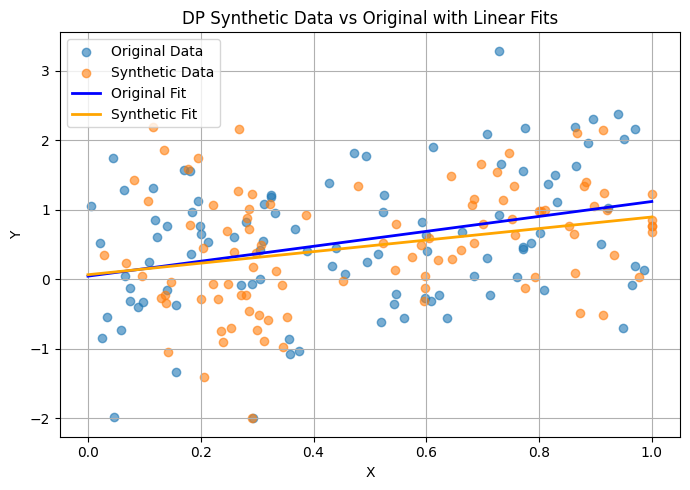

In [7]:
delta = 1e-5
eps = 5
mu = mu_from_eps_delta(eps, delta)
print("mu = ", mu)
priv_budget_bin = 1 / np.sqrt(82) * mu
priv_budget = 9 / np.sqrt(82) * mu



# Data generation
n_features = 1
sigma_lr = 1
n_samples = 100
theta = 200

x_lb, x_ub = 0, 1
y_lb, y_ub = -2, 4




np.random.seed(42)
X = np.random.uniform(x_lb, x_ub, size=(n_samples, n_features))
true_coeffs = np.random.uniform(1, 2, size=n_features)
Y = X @ true_coeffs + np.random.normal(0, sigma_lr, size=n_samples)

Y = np.clip(Y, y_lb, y_ub)
X = np.clip(X, x_lb, x_ub)
Y_norm_bound = max(np.abs(y_lb), np.abs(y_ub))

# Use per-feature bounds
x_bounds = [(x_lb, x_ub)]

# Binning + DP synthetic data generation
x_bins_list, sum_x, sum_y, counts, _ = privtree_binning_XY_with_theta(X, Y, x_bounds, mu, theta)
X_syn, Y_syn, *_ = DP_fy_sum_x_y_counts_syn_data(sum_x, sum_y, counts, x_bins_list, Y_norm_bound, priv_budget)

# Final clipping
X_syn = np.clip(X_syn, x_lb, x_ub)
Y_syn = np.clip(Y_syn, y_lb, y_ub)


#  Fit linear regression------------------------
lr_orig = LinearRegression().fit(X, Y)
lr_syn = LinearRegression().fit(X_syn, Y_syn)

x_range = np.linspace(x_lb, x_ub, 100).reshape(-1, 1)
y_pred_orig = lr_orig.predict(x_range)
y_pred_syn = lr_syn.predict(x_range)# GDP privacy conversion

# ------------------------
# Plotting
# ------------------------
plt.figure(figsize=(7, 5))
plt.scatter(X, Y, label="Original Data", alpha=0.6)
plt.scatter(X_syn, Y_syn, label="Synthetic Data", alpha=0.6)
plt.plot(x_range, y_pred_orig, color='blue', label="Original Fit", linewidth=2)
plt.plot(x_range, y_pred_syn, color='orange', label="Synthetic Fit", linewidth=2)
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("DP Synthetic Data vs Original with Linear Fits")
plt.grid(True)
plt.tight_layout()
plt.show()

mu = 1.1212418238183692


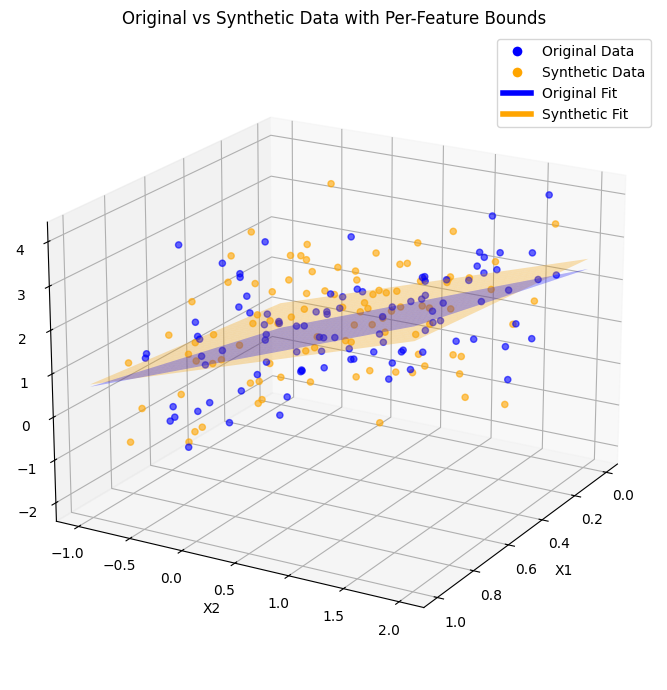

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

# GDP conversion
delta = 1e-5
eps = 5
mu = mu_from_eps_delta(eps, delta)
print("mu =", mu)

priv_budget_bin = 1 / np.sqrt(82) * mu
priv_budget = 9 / np.sqrt(82) * mu

# Params
n_features = 2
sigma_lr = 1
n_samples = 100
theta = 200

# Per-feature bounds
x_bounds = [(0, 1), (-1, 2)]
y_lb, y_ub = -2, 4

np.random.seed(42)
X1 = np.random.uniform(x_bounds[0][0], x_bounds[0][1], size=(n_samples, 1))
X2 = np.random.uniform(x_bounds[1][0], x_bounds[1][1], size=(n_samples, 1))
X = np.hstack([X1, X2])

true_coeffs = np.random.uniform(1, 2, size=n_features)
Y = X @ true_coeffs + np.random.normal(0, sigma_lr, size=n_samples)
Y = np.clip(Y, y_lb, y_ub)

# Clip X per feature
for i in range(n_features):
    X[:, i] = np.clip(X[:, i], x_bounds[i][0], x_bounds[i][1])

Y_norm_bound = max(np.abs(y_lb), np.abs(y_ub))

# Binning and synthetic generation
x_bins_list, sum_x, sum_y, counts, _ = privtree_binning_XY_with_theta(X, Y, x_bounds, mu, theta)
X_syn, Y_syn, *_ = DP_fy_sum_x_y_counts_syn_data(sum_x, sum_y, counts, x_bins_list, Y_norm_bound, priv_budget)

# Clip synthetic X per feature
for i in range(n_features):
    X_syn[:, i] = np.clip(X_syn[:, i], x_bounds[i][0], x_bounds[i][1])
Y_syn = np.clip(Y_syn, y_lb, y_ub)

# Fit regressions
lr_orig = LinearRegression().fit(X, Y)
lr_syn = LinearRegression().fit(X_syn, Y_syn)

# Meshgrid
x1_range = np.linspace(x_bounds[0][0], x_bounds[0][1], 30)
x2_range = np.linspace(x_bounds[1][0], x_bounds[1][1], 30)
X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)
X_grid = np.column_stack([X1_grid.ravel(), X2_grid.ravel()])
Y_pred_orig = lr_orig.predict(X_grid).reshape(X1_grid.shape)
Y_pred_syn = lr_syn.predict(X_grid).reshape(X1_grid.shape)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], Y, color='blue', alpha=0.6, label='Original Data')
ax.plot_surface(X1_grid, X2_grid, Y_pred_orig, color='blue', alpha=0.3)

ax.scatter(X_syn[:, 0], X_syn[:, 1], Y_syn, color='orange', alpha=0.6, label='Synthetic Data')
ax.plot_surface(X1_grid, X2_grid, Y_pred_syn, color='orange', alpha=0.3)

ax.set_title("Original vs Synthetic Data with Per-Feature Bounds")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("Y")
ax.view_init(elev=20, azim=30)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Original Data', markerfacecolor='blue', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Synthetic Data', markerfacecolor='orange', markersize=8),
    Line2D([0], [0], color='blue', lw=4, label='Original Fit'),
    Line2D([0], [0], color='orange', lw=4, label='Synthetic Fit')
]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()
